# Neural Differential Equation + Symbolic Regression with `diffrax` and `PySR`

## Symoblic Regression
Deep learning, including neural differential equations, typically produces `black-box' models. Once the model has been trained, it is a relatively opaque neural network whose mode of operation is essentially mysterious. It may be a good model, but a good model is not always the end goal. Scientific progress may be predicated upon understanding the model as well.

It is often desirable to obtain symbolic expressions -- an imprecise term which we use here to refer to some relatively shallow tree of primitive operations, for example $x \times ((y - 4.2) + z)$. These primitive operations typically include addition, multiplication, exponentiation and so on.

Symbolic regression is the process of deriving such expressions from data in an automated way. 


### Symbolic regression for dynamical systems

Suppose we observe paired samples of both $y(t)$ and $\frac{\mathrm{d} y}{\mathrm{d} t}(t)$, assumed to satisfy an equation of the form
$$
    \frac{\mathrm{d} y}{\mathrm{d} t}(t) = f(y(t)).
$$

Then SINDy seeks a symbolic expression for $f$ by selecting some features $f_i$ in advance, parameterising $f(y) = \sum_{i=1}^N \theta_i f_i(y)$, and directly regressing $\frac{\mathrm{d} y}{\mathrm{d} t}(t)$ against $\{f_i(y(t))\}_{i=1}^N$. A sparsity penalty such as $L^1$-regularisation is applied to $\theta$ so that only a few terms are selected in the final expression.

This procedure is simply standard LASSO (least absolute shrinkage and selection operator; or L1 regularization), and the dynamical character of the problem is essentially irrelevant. SINDy is arguably the dominant technique for symbolic regression with dynamical systems.

**However, SINDy has made two strong assumptions**: (a) that paired observations of both $y$ and $\frac{\mathrm{d} y}{\mathrm{d} t}(t)$ are available, and (b) that $f$ is a shallow tree of expressions -- just a linear combination of preselected features.

NDEs (Neural Differential Equations) offer ways to remove both of the assumptions.

- Removing assumption (a): no paired observations
    - Neural ODE ($f=f_\theta$ as a neural network)
- Removing assumption (b): deep symbolic expressions
    - Symbolic Distillation (Symbolic Regression across the learnt $f_\theta$)

This example combines neural differential equations with regularised evolution to discover the equations

$$
\frac{\mathrm{d} x}{\mathrm{d} t}(t) = \frac{y(t)}{1 + y(t)}
$$

$$
\frac{\mathrm{d} y}{\mathrm{d} t}(t) = \frac{-x(t)}{1 + x(t)}
$$

directly from data.

**References:**

This example appears as an example in Section 6.1 of:

```bibtex
@phdthesis{kidger2021on,
    title={{O}n {N}eural {D}ifferential {E}quations},
    author={Patrick Kidger},
    year={2021},
    school={University of Oxford},
}
```

Whilst drawing heavy inspiration from:

```bibtex
@inproceedings{cranmer2020discovering,
    title={{D}iscovering {S}ymbolic {M}odels from {D}eep {L}earning with {I}nductive
           {B}iases},
    author={Cranmer, Miles and Sanchez Gonzalez, Alvaro and Battaglia, Peter and
            Xu, Rui and Cranmer, Kyle and Spergel, David and Ho, Shirley},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2020},
}

@software{cranmer2020pysr,
    title={PySR: Fast \& Parallelized Symbolic Regression in Python/Julia},
    author={Miles Cranmer},
    publisher={Zenodo},
    url={http://doi.org/10.5281/zenodo.4041459},
    year={2020},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/symbolic_regression.ipynb).

In [ ]:
import tempfile

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.numpy as jnp
import optax  # https://github.com/deepmind/optax
import pysr  # https://github.com/MilesCranmer/PySR
import sympy
import sympy2jax  # https://github.com/google/sympy2jax

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now two helpers. We'll use these in a moment; skip over them for now.

In [ ]:
class Stack(eqx.Module):
    modules: list[eqx.Module]

    def __call__(self, x):
        assert x.shape[-1] == 2
        x0 = x[..., 0]
        x1 = x[..., 1]
        return jnp.stack([module(x0=x0, x1=x1) for module in self.modules], axis=-1)


def quantise(expr, quantise_to):
    if isinstance(expr, sympy.Float):
        return expr.func(round(float(expr) / quantise_to) * quantise_to)
    elif isinstance(expr, (sympy.Symbol, sympy.Integer)):
        return expr
    else:
        return expr.func(*[quantise(arg, quantise_to) for arg in expr.args])

Okay, let's get started.

We start by running the [Neural ODE example](./neural_ode.ipynb).
Then we extract the learnt neural vector field, and symbolically regress across this.
Finally we fine-tune the resulting symbolic expression.


In [ ]:
def main(
    symbolic_dataset_size=2000,
    symbolic_num_populations=100,
    symbolic_population_size=20,
    symbolic_migration_steps=4,
    symbolic_mutation_steps=30,
    symbolic_descent_steps=50,
    pareto_coefficient=2,
    fine_tuning_steps=500,
    fine_tuning_lr=3e-3,
    quantise_to=0.01,
):
    #
    # First obtain a neural approximation to the dynamics.
    # We begin by running the previous example.
    #

    # Runs the Neural ODE example.
    # This defines the variables `ts`, `ys`, `model`.
    print("Training neural differential equation.")
    %run '61_NeuralODE_diffrax.ipynb'

    #
    # Now symbolically regress across the learnt vector field, to obtain a Pareto
    # frontier of symbolic equations, that trades loss against complexity of the
    # equation. Select the "best" from this frontier.
    #

    print("Symbolically regressing across the vector field.")
    vector_field = model.func.mlp  # noqa: F821
    dataset_size, length_size, data_size = ys.shape  # noqa: F821
    in_ = ys.reshape(dataset_size * length_size, data_size)  # noqa: F821
    in_ = in_[:symbolic_dataset_size]
    out = jax.vmap(vector_field)(in_)
    with tempfile.TemporaryDirectory() as tempdir:
        symbolic_regressor = pysr.PySRRegressor(
            niterations=symbolic_migration_steps,
            ncycles_per_iteration=symbolic_mutation_steps,
            populations=symbolic_num_populations,
            population_size=symbolic_population_size,
            optimizer_iterations=symbolic_descent_steps,
            optimizer_nrestarts=1,
            procs=1,
            model_selection="score",
            progress=False,
            tempdir=tempdir,
            temp_equation_file=True,
        )
        symbolic_regressor.fit(in_, out)
        best_expressions = [b.sympy_format for b in symbolic_regressor.get_best()]

    #
    # Now the constants in this expression have been optimised for regressing across
    # the neural vector field. This was good enough to obtain the symbolic expression,
    # but won't quite be perfect -- some of the constants will be slightly off.
    #
    # To fix this we now plug our symbolic function back into the original dataset
    # and apply gradient descent.
    #

    print("\nOptimising symbolic expression.")

    symbolic_fn = Stack([sympy2jax.SymbolicModule(expr) for expr in best_expressions])
    symbolic_model = eqx.tree_at(lambda m: m.func.mlp, model, symbolic_fn)  # noqa: F821

    @eqx.filter_grad
    def grad_loss(symbolic_model):
        vmap_model = jax.vmap(symbolic_model, in_axes=(None, 0))
        pred_ys = vmap_model(ts, ys[:, 0])  # noqa: F821
        return jnp.mean((ys - pred_ys) ** 2)  # noqa: F821

    optim = optax.adam(fine_tuning_lr)
    opt_state = optim.init(eqx.filter(symbolic_model, eqx.is_inexact_array))

    @eqx.filter_jit
    def make_step(symbolic_model, opt_state):
        grads = grad_loss(symbolic_model)
        updates, opt_state = optim.update(grads, opt_state)
        symbolic_model = eqx.apply_updates(symbolic_model, updates)
        return symbolic_model, opt_state

    for _ in range(fine_tuning_steps):
        symbolic_model, opt_state = make_step(symbolic_model, opt_state)

    #
    # Finally we round each constant to the nearest multiple of `quantise_to`.
    #

    trained_expressions = []
    for symbolic_module in symbolic_model.func.mlp.modules:
        expression = symbolic_module.sympy()
        expression = quantise(expression, quantise_to)
        trained_expressions.append(expression)

    print(f"Expressions found: {trained_expressions}")

Training neural differential equation.
Step: 0, Loss: 0.19398906826972961, Computation time: 5.315373659133911
Step: 100, Loss: 0.009585139341652393, Computation time: 0.07348418235778809
Step: 200, Loss: 0.007810886483639479, Computation time: 0.07425236701965332
Step: 300, Loss: 0.004012477584183216, Computation time: 0.07274103164672852
Step: 400, Loss: 0.0014371669385582209, Computation time: 0.07404017448425293
Step: 499, Loss: 0.0005228825029917061, Computation time: 0.07404565811157227
Step: 0, Loss: 0.03129379078745842, Computation time: 4.796645164489746
Step: 100, Loss: 0.00592073192819953, Computation time: 0.1042473316192627
Step: 200, Loss: 0.003086335491389036, Computation time: 0.10576725006103516
Step: 300, Loss: 0.003560424316674471, Computation time: 0.10859346389770508
Step: 400, Loss: 0.0011323773069307208, Computation time: 0.1123969554901123
Step: 499, Loss: 0.0006006540497764945, Computation time: 0.10791659355163574


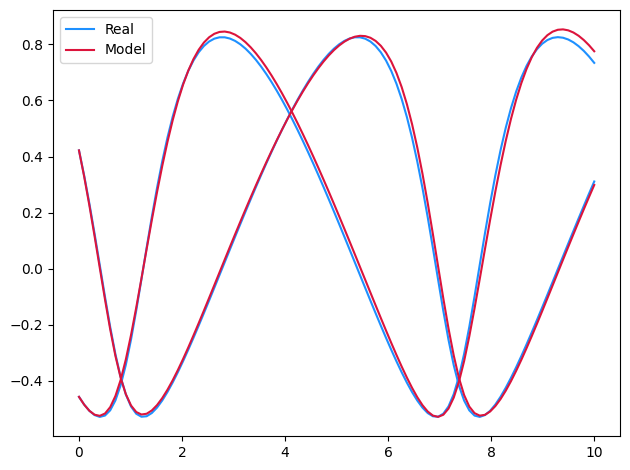

Symbolically regressing across the vector field.


Compiling Julia backend...
[ Info: Started!
[ Info: Final populations:
[ Info: Output 1:
[ Info: Output 2:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.565e-02  1.594e+01  y₀ = x₁
3           4.626e-02  3.080e-01  y₀ = x₁ - 0.19848
5           1.274e-03  1.796e+00  y₀ = x₁ / (x₁ + 1.0446)
7           7.228e-04  2.835e-01  y₀ = (x₁ * 1.0499) / (x₁ + 1.0434)
9           7.228e-04  3.874e-06  y₀ = ((x₁ / 0.83672) / 1.1383) / (x₁ - -1.0434)
11          5.340e-04  1.513e-01  y₀ = (0.0075194 - (x₁ / (2.109 - (x₁ * -1.9795)))) * -2.1...
                                       49
13          5.340e-04  1.490e-07  y₀ = -0.016151 - (((x₁ / (2.8081 - (x₁ * -2.6358))) * 2.4...
                                       013) / -0.83923)
17          5.260e-04  3.773e-03  y₀ = ((x₀ - 152.28) * (-0.090939 - ((x₁ / (314.08 - (x₁ *...
                                        -294.89))) * -1795.1))) / -853.53
19          5.145e-04  1.111e-02  y₀ = (x₁ * (((((-0.6452 / ((x₁ + 1.1241) * -0.30721)) + x...
  

In [ ]:
main()